In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

## Load the data

In [2]:
# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

let's check what we got in the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


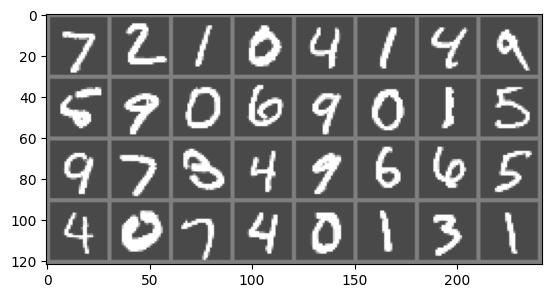

In [3]:
images, labels = next(iter(testloader))

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

imshow(tv.utils.make_grid(images))

## The basic convolutional model

In [4]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True))

        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size=5),
            nn.ReLU(True),
            nn.Sigmoid())

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Let's traing this model on the GPU 

In [5]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Model and other definitions
num_epochs = 1
batch_size = 128
model = Autoencoder().to(device)  # Move model to GPU
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

# Assuming `dataloader` is already defined

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)  # Move data to GPU
        img.requires_grad_(True)
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/1], loss:0.9751


## Vizualizing reconstructed images

In [7]:
def visualize_reconstruction(model, data_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            break  # Only take the first batch

    inputs = inputs[:num_images]
    outputs = outputs[:num_images]

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(inputs[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        axes[1, i].imshow(outputs[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.show()

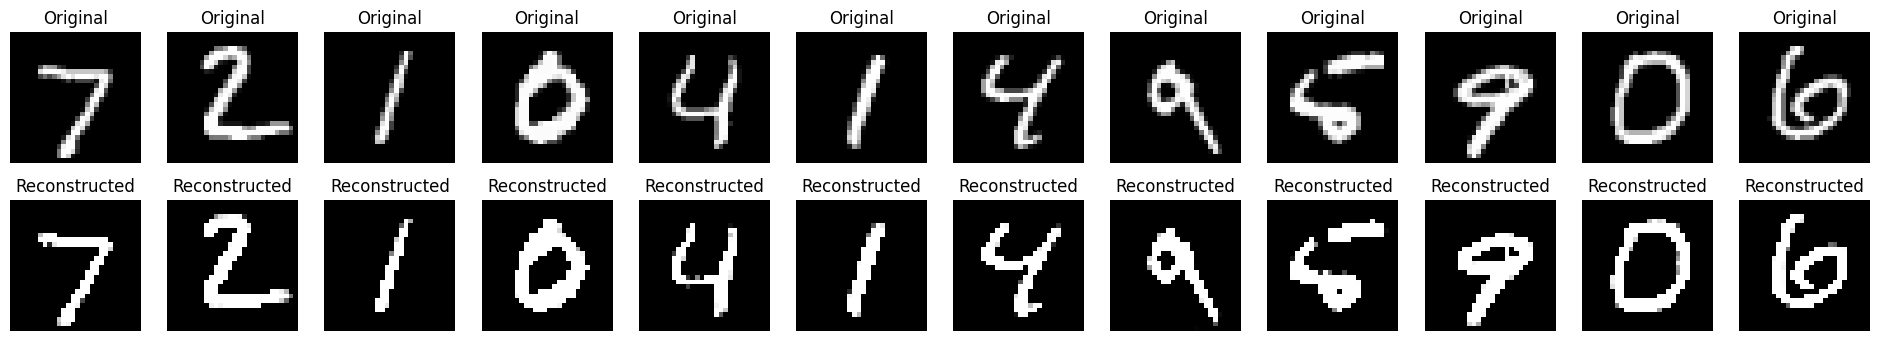

In [8]:
visualize_reconstruction(model, testloader, num_images=12)

## FAST.ai way

In [9]:
from fastai.vision.all import *
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb.to(device))
            n = len(xb.to(device))
            count += n
            tot_loss += loss_func(pred,xb.to(device)).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [13]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            xb = xb.to(device)
            loss = loss_func(model(xb), xb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        eval(model, loss_func, valid_dl, epoch)

In [11]:
model2 = Autoencoder().to(device)

In [14]:
optimizer2 = torch.optim.Adam(model2.parameters(), weight_decay=1e-5, lr=0.1)
opt = torch.optim.SGD(model2.parameters(), lr=0.01)
fit(2, model2, distance, opt, dataloader, testloader)

0 1.038
1 1.033


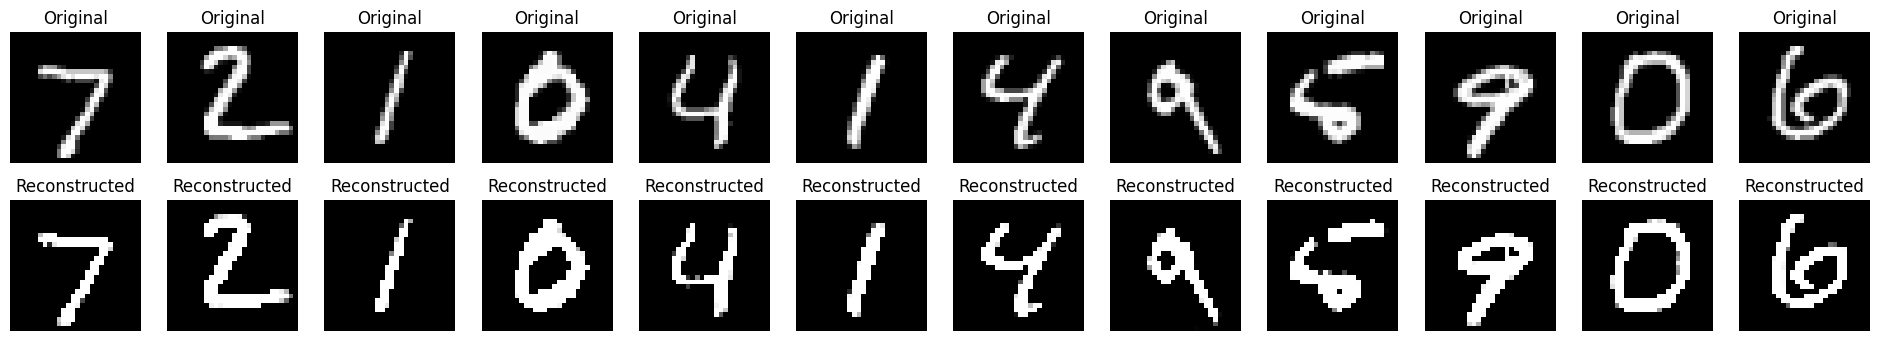

In [16]:
visualize_reconstruction(model, testloader, num_images=12)

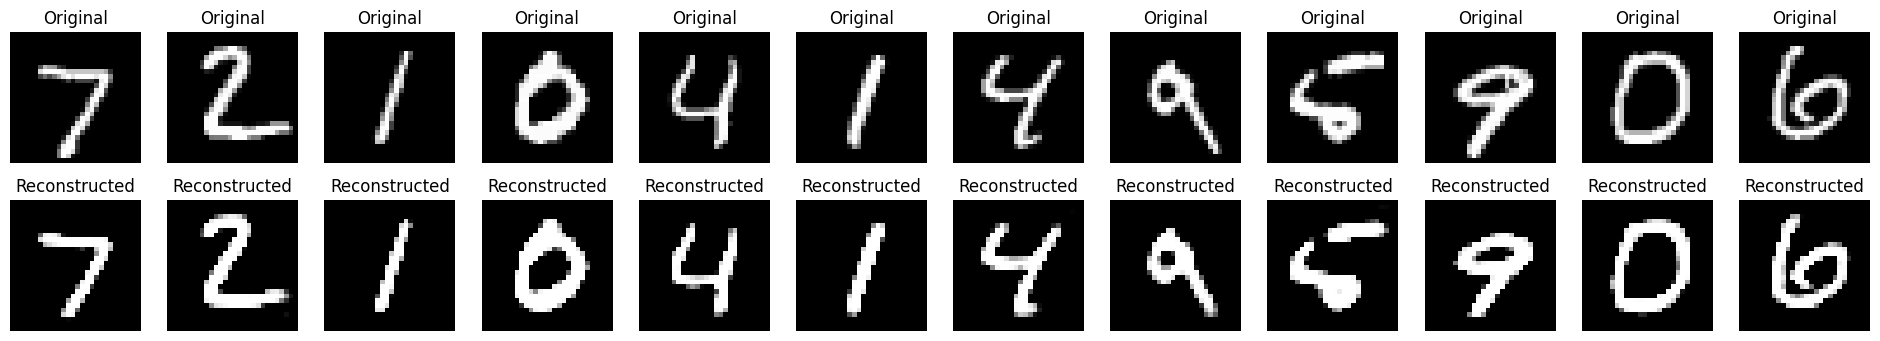

In [17]:
visualize_reconstruction(model2, testloader, num_images=12)